In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]
torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cpu


In [2]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2()

In [3]:
# tacotron2

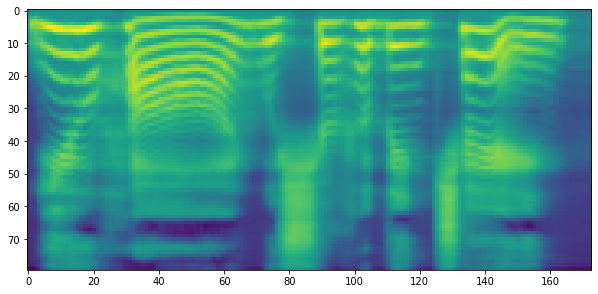

In [4]:
text = "nee hao, wo sher hu bing cheung"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, attention = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'co

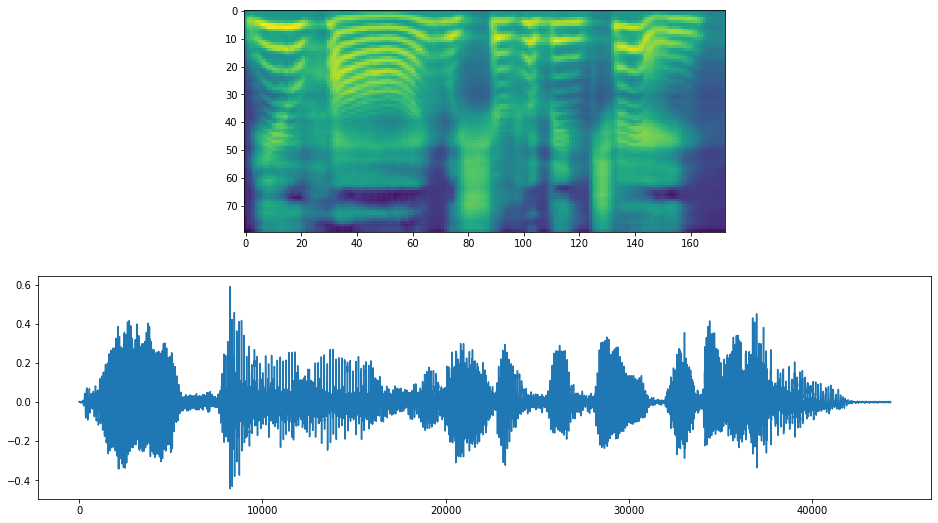

In [5]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), interpolation='none')
ax2.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)

# 初步训练/单说话人少量句子

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# import utils.dataset
from utils.dataset import AiShell3PersonDataset, MelLoaderGenerator, RawLoaderGenerator, AiShell3Dataset
from pypinyin import lazy_pinyin

In [8]:
from torchaudio.pipelines._tts.utils import _get_chars
labels = _get_chars() + ('1', '2', '3', '4', '5')
labels[0]

'_'

In [9]:
def raw_audio_transform(sample, sample_rate=None):
        audio = sample['audio']
        # audio = torchaudio.functional.vad(audio, sample_rate, trigger_level=5)
        audio = audio / torch.abs(audio).max()*0.15
        text = sample['text']
        text = text.split(' ')
        pinyin = [text[i] for i in range(len(text)) if i%2==1]
        pinyin = ' '.join(pinyin) # 使用空格分离单字
        chinese = [text[i] for i in range(len(text)) if i%2==0]
        return {'audio':audio,
                'text': '. '+pinyin+' ..', # 句子结尾加句号
                'chinese': chinese}
sample_rate = 22050               
# dataset = AiShell3PersonDataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform, person_id='SSB0011', sample_rate=sample_rate)
dataset = AiShell3Dataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform, sample_rate=sample_rate)
torchaudio.save('_assets/temp.wav', dataset[0]['audio'], sample_rate)
dataset[0]

{'audio': tensor([[1.2767e-05, 1.8190e-05, 1.6576e-05,  ..., 6.1332e-04, 6.7303e-04,
          4.7237e-04]]),
 'text': '. zhua1 zhu4 hu4 lian2 wang3 lang4 chao2 ying2 lai2 xin1 de5 fa1 zhan3 ..',
 'chinese': ['抓', '住', '互', '联', '网', '浪', '潮', '迎', '来', '新', '的', '发', '展']}

In [10]:
loaderGenerator = RawLoaderGenerator(labels, k_size=5)
loaderGenerator.version

'0.02'

In [11]:
batch_size = 8
train_set, test_set = dataset.split([1,0])
train_loader = loaderGenerator.dataloader(train_set, batch_size=batch_size)
len(train_set), len(test_set)

(63262, 0)

测试随机提取几组数据

In [12]:
steps = 3
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    steps -= 1

torch.Size([7, 116951]) torch.Size([7, 110])
torch.Size([7, 117111]) torch.Size([7, 114])
torch.Size([7, 103453]) torch.Size([7, 75])


测试sort后是否顺序正常，听一下音频和文字是否相符

In [13]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    # sample_batched['audio'][0]
    torchaudio.save('_assets/temp.wav', sample_batched['audio'][0].unsqueeze(0), sample_rate)
    print(loaderGenerator.id2label(sample_batched['target'][0]))
    print(''.join(sample_batched['chinese'][0]))
    print(sample_batched['target_len'])
    steps -= 1

. bai3 fen1 zhi1 qi1 er2 shang1 ye4 dai4 kuan3 li4 lv4 duo1 zai4 bai3 fen1 zhi1 wu2 yi3 shang4 ..
百分之七而商业贷款利率多在百分之五以上
tensor([97, 89, 80, 60, 38, 35])


数据绘制mel

In [14]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
safe_log = lambda x: torch.log(x+2**(-15))

torch.Size([54022])
tensor(0.1500)
torch.Size([80, 160])


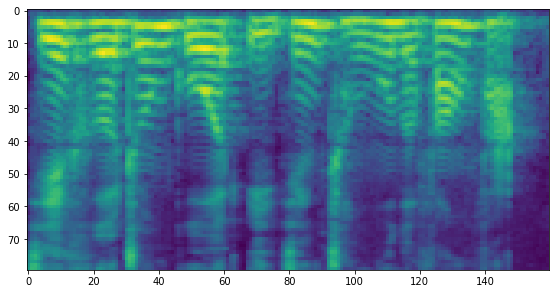

In [15]:
from utils.audio import trim_mel_silence

audio_test = dataset[631]['audio'][0]
print(audio_test.shape)
print(torch.abs(audio_test).max())
# audio_test = audio_test / torch.abs(audio_test).max()*0.15
# audio_test = torchaudio.functional.vad(audio_test, sample_rate, trigger_level=5)
mel_test = mel_transform(audio_test)
mel_test = trim_mel_silence(mel_test, ratio=50, min_threshold=0.1)
print(mel_test.shape)
plt.imshow(safe_log(mel_test), interpolation='none')

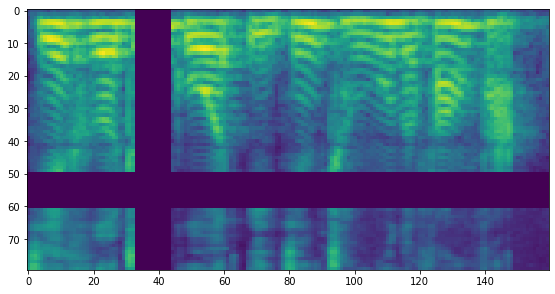

In [16]:
from torchaudio.transforms import FrequencyMasking, TimeMasking
f_mask = FrequencyMasking(freq_mask_param=25)
t_mask = TimeMasking(time_mask_param=25)
x = mel_test.unsqueeze(0)
x = t_mask(x) # time mask
x = t_mask(x) # 2nd time mask
x = f_mask(x) # feature mask
plt.imshow(safe_log(x.squeeze()), interpolation='none')

In [17]:
# with torch.no_grad():
#     waveforms = waveglow.infer(safe_log(mel_test).unsqueeze(0))
# torchaudio.save("_assets/temp.wav", waveforms[0:1].cpu(), sample_rate=sample_rate)

In [18]:
my_tacotron2 = bundle.get_tacotron2()

In [19]:
from torch.nn.utils.rnn import pad_sequence

In [20]:
new_embedding = torch.nn.Embedding(len(labels), tacotron2.embedding.embedding_dim)

In [21]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].shape

torch.Size([38, 512])

In [22]:
tacotron2.embedding.weight.shape

torch.Size([38, 512])

In [23]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].data=tacotron2.embedding.weight.data

In [24]:
my_tacotron2.embedding=new_embedding

测试跑一个数据

In [25]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    steps -= 1
    print('audio', sample_batched['audio'].shape, 'target', sample_batched['target'].shape)
    audio = sample_batched['audio']
    tokens = sample_batched['target']
    audio_len = sample_batched['audio_len']
    tokens_len = sample_batched['target_len']
    # print(tokens.shape)
    # print(audio[1][:audio_len[1]].shape)
    # break
    mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
    print('mel', mels_list[0].shape)
    print('tokens', loaderGenerator.id2label(tokens[0]))
    mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
    # print('mel_length', mel_length)
    max_audio_length = torch.max(mel_length)
    mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
    print('mels', mels_tensor.shape)
    org_mel, pos_mel, stop_token, attentions = my_tacotron2.forward(tokens, tokens_len, mels_tensor, mel_length)
    print('output',org_mel.shape, pos_mel.shape, stop_token.shape, attentions.shape)
    true_stop_token = torch.zeros(stop_token.shape)
    for i in range(true_stop_token.shape[0]):
        true_stop_token[i][mel_length[i]:]+=1.0
    show_id = 4
    stop_token = torch.sigmoid(stop_token)
    # print(stop_token[show_id][200:])
    for i in range(len(stop_token[show_id])):
        if stop_token[show_id][i] > 0.5:
            print('stop',i)
            break
    

audio torch.Size([7, 99222]) target torch.Size([7, 83])
mel torch.Size([336, 80])
tokens . xu2 guo2 hua2 dai4 zhe5 ta1 men5 qu4 zhao3 chang1 ping2 zhi1 hang2 xie2 shang1 ..
mels torch.Size([7, 80, 388])
output torch.Size([7, 80, 388]) torch.Size([7, 80, 388]) torch.Size([7, 388]) torch.Size([7, 388, 83])


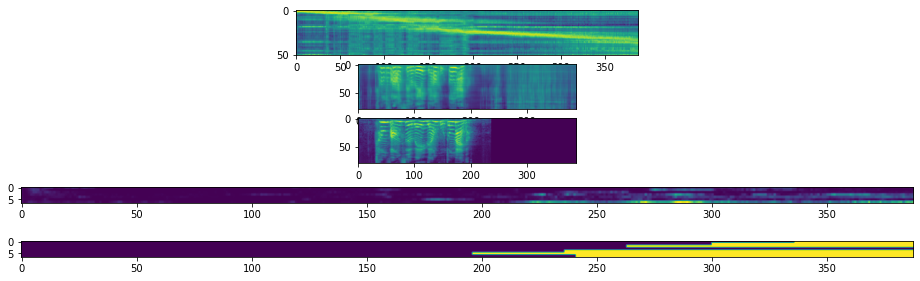

In [26]:
if __name__ =='__main__':
    fig, axs = plt.subplots(5)
    axs[0].imshow(safe_log(attentions[show_id][:, :tokens_len[show_id]]).detach().transpose(0,1).numpy())
    axs[1].imshow(pos_mel[show_id].detach().numpy())
    axs[2].imshow(mels_tensor[show_id].detach().numpy())
    axs[3].imshow(safe_log(stop_token).detach().numpy())
    axs[4].imshow(true_stop_token.detach().numpy())

## 训练

正式训练中我们需要几个loss一起训练
1. org_mel vs true_mel
2. pos_mel vs true_mel
3. sigmoid(stop_token) vs 0 and 1

那么，开始吧

In [27]:
# %load_ext autoreload
# %autoreload 2

In [28]:
from model.MyTacotron2 import MyTacotron2
model = MyTacotron2(labels, 
    decoder=bundle.get_tacotron2().decoder, 
    postnet=bundle.get_tacotron2().postnet, 
    speaker_emb_size=128
    ).to(device)

In [29]:
# if __name__ == '__main__':
#     spec = torch.randn(5, 11, 4) # bs, L, mel_in
#     lens=torch.tensor([1,2,3,4,5])
#     out = model.speaker_encoder(spec, lens) # bs, out_dim
#     print(out.shape)


In [30]:
model.parameters()

<generator object Module.parameters at 0x7ff47a93e030>

In [31]:
# params = model.parameters()
params = list(model.embedding.parameters())+list(model.encoder.parameters())+list(model.speaker_encoder.parameters())
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
initial_epoch = 0
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
cos_loss = torch.nn.CosineEmbeddingLoss()
mean = lambda x: sum(x)/len(x)

In [32]:
def save_log(file_name, log, mode='a', path = './log/n1-'):
    with open(path+file_name, mode) as f:
        if mode == 'a':
            f.write('\n')
        if type(log) is str:
            f.write(log)
            print(log)
        else:
            log = [str(l) for l in log]
            f.write(' '.join(log))
            print(' '.join(log))

In [33]:
def dump_model(EPOCH, LOSS, PATH):
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

def save_temp(EPOCH, LOSS):
    PATH = f"./checkpoint/tacotron2/model_temp.pt"
    dump_model(EPOCH, LOSS, PATH)
    
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/tacotron2/model_{EPOCH}_{'%.3f' % LOSS}.pt"
    dump_model(EPOCH, LOSS, PATH)

In [34]:
def train(epoch=1):
    train_loss_q = []
    test_loss_q = []
    for epoch in range(initial_epoch, epoch):
        
        batch_train_loss = []
        for i_batch, sample_batched in enumerate(train_loader):
            model.train()
            # Step 1. Prepare Data
            audio = sample_batched['audio']
            tokens = sample_batched['target']
            audio_len = sample_batched['audio_len']
            tokens_len = sample_batched['target_len']

            # Step 2. Run our forward pass
            mels_list = [safe_log(trim_mel_silence(mel_transform(audio[i][:audio_len[i]]))).transpose(0,1) for i in range(len(audio_len))]
            mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
            mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
            print('(mels_tensor, mel_length)', (mels_tensor.shape, mel_length.shape))
            speaker_emb = model.speaker_encoder(mels_tensor.transpose(1,2), mel_length)
            # speaker_emb = None

            org_mel, pos_mel, stop_token, _ = model.forward(tokens, tokens_len, mels_tensor, mel_length, speaker_emb, alpha=0.5)
            loss1 = mse_loss(mels_tensor, org_mel)
            loss1 += mse_loss(mels_tensor, pos_mel)

            reconstruct_speaker_emb = model.speaker_encoder(pos_mel.transpose(1,2), mel_length)
            loss2 = cos_loss(speaker_emb, reconstruct_speaker_emb, torch.ones_like(tokens_len))

            true_stop_token = torch.zeros(stop_token.shape).to(device)
            for i in range(true_stop_token.shape[0]):
                true_stop_token[i][mel_length[i]:]+=1.0
            loss3 = bce_loss(torch.sigmoid(stop_token), true_stop_token)
            
            # Step 3. Run our backward pass
            optimizer.zero_grad()
            loss = loss1 + loss2 + loss3
            loss.backward()
            optimizer.step()

            if loss.item()!=loss.item(): # if loss == NaN, break
                print('NaN hit!')
                exit()
            
            print('item', loss1.item()+loss2.item()+loss3.item())
            print('shape', loss1.shape+loss2.shape+loss3.shape)
            batch_train_loss.append(loss1.item()+loss2.item()+loss3.item())

            if i_batch % (1000 // batch_size) == 0: # log about each 1000 data
                # test_loss = test()
                test_loss = 0
                train_loss = mean(batch_train_loss)
                test_loss_q.append(test_loss)
                train_loss_q.append(train_loss)
                save_log(f'e{epoch}.txt', ['🟣 epoch', epoch, 'data', i_batch*batch_size, 
                    'lr', scheduler.get_last_lr(), 
                    'train_loss', train_loss, 'test_loss', test_loss])
                # save_temp(epoch, test_loss) # save temp checkpoint
                # test_decoder(epoch, 5)
            break
            
        scheduler.step()
        save_checkpoint(epoch, mean(test_loss_q))
        save_log(f'e{epoch}.txt', ['============= Final Test ============='])
        # test_decoder(epoch, 10) # run some sample prediction and see the result

In [35]:
print(model.version)
train(1)


0.05
(mels_tensor, mel_length) (torch.Size([6, 80, 254]), torch.Size([6]))
item 62.59284745622426
shape torch.Size([])
🟣 epoch 0 data 0 lr [0.005] train_loss 62.59284745622426 test_loss 0
============= Final Test =============


In [36]:
def get_speaker_emb(model, path):
    waveform, sr = torchaudio.load(path)
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    mels_tensor = safe_log(mel_transform(waveform))
    # print(mels_tensor.shape)
    speaker_emb = model.speaker_encoder(mels_tensor.transpose(1,2), [mels_tensor.shape[-1]])
    # print(speaker_emb.shape)
    return speaker_emb

get_speaker_emb(model, './_assets/test.wav')[:,:20]

tensor([[-0.1024, -0.1846,  0.1520, -0.0390,  0.0329, -0.0327, -0.0320, -0.0884,
         -0.0016, -0.0345, -0.0952,  0.2641,  0.0232,  0.0464,  0.1116, -0.0009,
          0.0373,  0.0640,  0.1249, -0.0436]], grad_fn=<SliceBackward0>)

## 测试训练好的模型

In [37]:
processor._tokens = labels

In [38]:
from os.path import exists
def load_checkpoint(path):
    if exists(path):
        print('path exist, loading...')
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
# LOAD_PATH = './checkpoint/tacotron2/model_20_0.000.pt'
LOAD_PATH = './checkpoint/tacotron2/model_temp.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_checkpoint(LOAD_PATH)
model.eval()
print('')

path exist, loading...



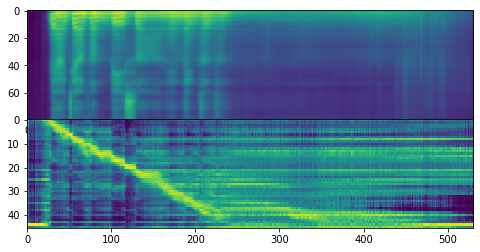

In [94]:
text = "liang3 jia1 feng1 bie2 shi4 hang2 ye4 nei4 ge4 zi4 zhuan1"

girl_voice = '/scratch/bh2283/data/data_aishell3/train/wav/SSB0057/SSB00570002.wav'
man_voice = '/scratch/bh2283/data/data_aishell3/train/wav/SSB0375/SSB03750003.wav'
model.eval()
with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, attention = model.infer(processed, lengths, get_speaker_emb(model, man_voice))

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 4))
fig.subplots_adjust(hspace=0)
ax1.imshow(spec[0].cpu().detach(), aspect='auto', interpolation='none')
ax2.imshow(safe_log(attention[0].cpu().detach().transpose(0,1)), aspect='auto', interpolation='none')

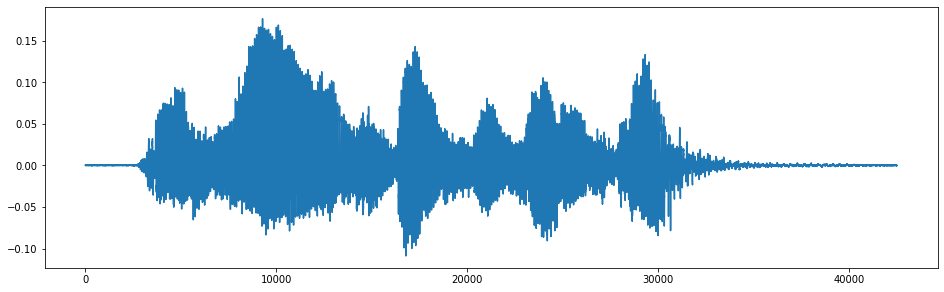

In [73]:
with torch.no_grad():
    waveforms = waveglow.infer(spec[:,:,:200])

# fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
# ax1.imshow(spec[0].cpu().detach())
plt.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=sample_rate)

In [82]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    steps -= 1
    print('audio', sample_batched['audio'].shape, 'target', sample_batched['target'].shape)
    audio = sample_batched['audio']
    tokens = sample_batched['target']
    audio_len = sample_batched['audio_len']
    tokens_len = sample_batched['target_len']
    # print(tokens.shape)
    # print(audio[1][:audio_len[1]].shape)
    # break
    mels_list = [safe_log(trim_mel_silence(mel_transform(audio[i][:audio_len[i]]), ratio=10)).transpose(0,1) for i in range(len(audio_len))]
    print('mel', mels_list[0].shape)
    print('tokens', loaderGenerator.id2label(tokens[0]))
    mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
    # print('mel_length', mel_length)
    max_audio_length = torch.max(mel_length)
    mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=torch.log(torch.tensor(2**(-15)))).permute(0,2,1)
    print('mels', mels_tensor.shape)
    speaker_emb = model.speaker_encoder(mels_tensor.transpose(1,2), mel_length)

    # torch.nn.init.xavier_uniform_(model.decoder.gate_layer.weight, gain=torch.nn.init.calculate_gain('linear'))

    org_mel, pos_mel, stop_token, attentions = model.forward(tokens, tokens_len, mels_tensor, mel_length, speaker_emb, alpha=1)
    print('output',org_mel.shape, pos_mel.shape, stop_token.shape, attentions.shape)

    true_stop_token = torch.zeros(stop_token.shape).to(device)
    for i in range(true_stop_token.shape[0]):
        true_stop_token[i][mel_length[i]:]+=1.0
    # loss3 = bce_loss(torch.sigmoid(stop_token), true_stop_token)

    show_id = 1
    stop_token = torch.sigmoid(stop_token)
    # print(stop_token[show_id][200:])
    for i in range(len(stop_token[show_id])):
        if stop_token[show_id][i] > 0.5:
            print('stop',i)
            break
    

audio torch.Size([5, 118318]) target torch.Size([5, 108])
mel torch.Size([373, 80])
tokens . liang3 jia1 feng1 bie2 shi4 hang2 ye4 nei4 ge4 zi4 zhuan1 zhu4 de5 chan2 pin3 xian4 long2 tou2 lao3 da4 ..
mels torch.Size([5, 80, 373])
output torch.Size([5, 80, 373]) torch.Size([5, 80, 373]) torch.Size([5, 373]) torch.Size([5, 373, 108])
stop 338


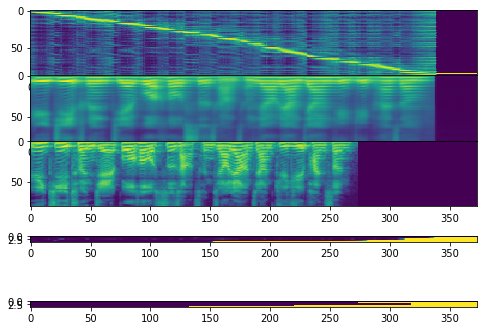

In [84]:
if __name__ =='__main__':
    fig, axs = plt.subplots(5, figsize=(8, 6))
    fig.subplots_adjust(hspace=0)
    aspect = 'auto'
    axs[0].imshow(safe_log(attentions[show_id][:, :tokens_len[show_id]]).detach().transpose(0,1).numpy(), aspect=aspect, interpolation='none')
    axs[1].imshow(pos_mel[show_id].detach().numpy(), aspect=aspect, interpolation='none')
    axs[2].imshow(mels_tensor[show_id].detach().numpy(), aspect=aspect, interpolation='none')
    # axs[0].set_aspect('equal')
    # axs[1].set_aspect('equal')
    # axs[2].set_aspect('equal')
    # plt.tight_layout()
    
    axs[3].imshow(safe_log(stop_token).detach().numpy(), interpolation='none')
    axs[4].imshow(true_stop_token.detach().numpy(), interpolation='none')


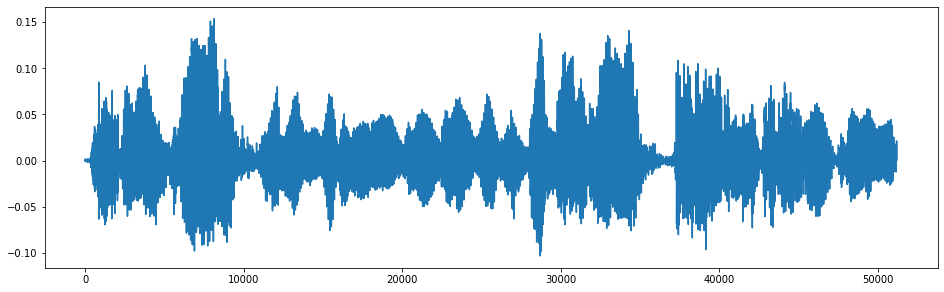

In [79]:
with torch.no_grad():
    # waveforms = waveglow.infer(pos_mel[:1,:,:200])
    waveforms = waveglow.infer(mels_tensor[:1,:,:200])
plt.plot(waveforms[0].cpu().detach())
torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=sample_rate)

In [44]:
girl_voice = '/scratch/bh2283/data/data_aishell3/train/wav/SSB0005/SSB00050001.wav'
man_voice = '/scratch/bh2283/data/data_aishell3/train/wav/SSB0375/SSB03750003.wav'
model.eval()
with torch.inference_mode():
    speaker_emb = get_speaker_emb(model, girl_voice)
    # print(speaker_emb)

# fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 4))
# # fig.subplots_adjust(hspace=0)
# ax1.imshow(safe_log(speaker_emb), aspect='auto', interpolation='none')
# ax2.imshow(speaker_emb, aspect='auto', interpolation='none')